# TAR PROJECT - TEXT SEGMENTATION

### Authors: Mirela Oštrek and Luka Dulčić

In [1]:
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
import string
import os

Helper functions

In [2]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stemmer = PorterStemmer()
# irrelevant characters specific for choi dataset
choi_noise = ['--', '\'\'', '``', ';', '..', '...', 'afj', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = map(lambda t: t.lower(), tokens)
    tokens = filter(lambda t: t not in string.punctuation, tokens)
    tokens = filter(lambda t: t not in ENGLISH_STOP_WORDS, tokens)
    tokens = filter(lambda t: t not in choi_noise, tokens)
    tokens = filter(lambda t: t[0] != '\'', tokens)#remove strings like "'s" 
    stems = stem_tokens(tokens, stemmer)
    return stems

def get_filepaths(directory):

    file_paths = []

    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)

    return file_paths

def doc_to_seg_string(n_sent, boundaries):
    '''
    Creates string which represents documents (eg. '0000100001000')
    where 0 marks sentence and 1 marks boundary between segments.
    This string is used for evaluating topic tiling algorithm with Pk
    and WD measure.
    
    @param n_sent: number of sentences in document.
    @param boundaries: indices of boundaries between segments
    '''
    seg_string = ''
    for i in range(n_sent):
        if i in boundaries:
            seg_string += '10'
        else:
            seg_string += '0'
    return seg_string

def print_top_words(model, feature_names, n_top_words):
    '''
    Prints top words for each topic where "model" is LDA model.
    '''
    for topic_idx, topic in enumerate(model.components_):
        print "Topic #%d:" % topic_idx
        print " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print
    
def max_left(sequence, ind_curr):
    max = sequence[ind_curr]
    while (ind_curr != 0) and (max <= sequence[ind_curr-1]):
        max = sequence[ind_curr-1]
        ind_curr -= 1 
    return max

def max_right(sequence, ind_curr):
    max = sequence[ind_curr]
    while (ind_curr != (len(sequence)-1)) and (max <= sequence[ind_curr+1]):
        max = sequence[ind_curr+1]
        ind_curr += 1  
    return max

Loading dataset

In [3]:
class Document:
    
    def __init__(self, path):
        '''
        @param sentences: list of document sentences
        @param boundaries: list of positions where segments boundaries are
        @param segment_divider: string which indicates boundary between two segments
        '''
        self.sentences = []
        self.boundaries = []
        self.segment_divider = "=========="
        
        self.load_document(path)
        
    def load_document(self, path):
        '''
        @param path: path to file where document is
        '''
        sentences = self.get_valid_sentences(path)
        for i, sentence in enumerate(sentences):
            if sentence != self.segment_divider:
                self.sentences.append(sentence)
            else:
                self.boundaries.append(i - len(self.boundaries))
        #remove unecessary boundaries at beginning and the end
        del self.boundaries[0]
        del self.boundaries[-1]
        
    def get_valid_sentences(self, path):
        '''
        Reads all sentences from file and filters out invalid ones.
        Invalid sentences are sentences which are empty or contain
        only irrelevant tokens like stop words, punctuations, etc.
        '''
        sentences = []
        with open(path, 'r') as fd:
            for line in fd:
                line = line.rstrip('\n')
                if tokenize(line):
                    # if line is valid
                    sentences.append(line)
        return sentences
        
    
    def to_text(self):
        '''
        Returns this documents as appendend string of sentences.
        '''
        return '\n'.join(self.sentences)
    
    def to_segments(self):
        '''
        Returns this document as list of segments based on boundaries.
        '''
        segments = []
        for i, boundary in enumerate(self.boundaries):
            if i == 0:
                segments.append(' '.join(self.sentences[0:boundary]))
            else:
                last_b = self.boundaries[i - 1]
                segments.append(' '.join(self.sentences[last_b:boundary]))
        segments.append(' '.join(self.sentences[self.boundaries[-1]:]))
        return segments

In [24]:
train_data_path = "choi_data/1/3-5/"
test_data_path = "choi_data/1/3-5/45.ref"

files_paths = get_filepaths(train_data_path)
files_paths.remove(test_data_path)

documents = []
for path in files_paths:
    if path != test_data_path:
        documents.append(Document(path))

test_document = Document(test_data_path)

#### ACTUAL WORK

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 10

train_data = []
for document in documents:
    train_data.extend(document.to_segments())

vectorizer = CountVectorizer(max_df=0.95, min_df=2, tokenizer=tokenize, stop_words='english')
X = vectorizer.fit_transform(train_data)

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=100, n_jobs=-1, doc_topic_prior=5, topic_word_prior=0.01, random_state=273)
lda.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=5,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_jobs=-1, n_topics=10, perp_tol=0.1, random_state=273,
             topic_word_prior=0.01, total_samples=1000000.0, verbose=0)

## Topic Tiling

In [27]:
tokenized_sentences = [tokenize(sentence) for sentence in test_document.sentences]

In [28]:
sentence_vectors = []
#TODO it is suggested to remove sentences with less than 5 tokens for better performance
for sentence in tokenized_sentences:
    vector = np.zeros(n_topics)
    for token in sentence:
        #IMPORTANT WHAT TO DO IF TOKEN IS NOT IN DICTIONARY?
        if token in vectorizer.vocabulary_:
            index = lda.components_[:, vectorizer.vocabulary_[token]].argmax()
            vector[index] += 1
    sentence_vectors.append(vector)

sentence_vectors = filter(lambda v: sum(v) > 0, sentence_vectors) # remove empty vectors (vectors with all elements 0)

In [12]:
from scipy import spatial
import matplotlib.pyplot as plt
from __future__ import division
from scipy.signal import argrelextrema
from nltk.metrics.segmentation import pk
from nltk.metrics.segmentation import windowdiff
%pylab inline

Populating the interactive namespace from numpy and matplotlib


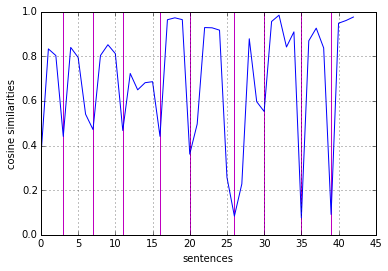

00010001000001000001000010000010000010000010000100000
00010000100001000001000010000001000010000010000100000
Pk measure result 0.078431


In [30]:
cosine_similarities = np.empty(0)
depth_scores = []

#racunam cos similarities
for i in range(0, len(sentence_vectors)-1):
    sim = 1 - spatial.distance.cosine(sentence_vectors[i], sentence_vectors[i+1])
    cosine_similarities = np.append(cosine_similarities, sim)

#get all local minima
split_candidates_indices = argrelextrema(cosine_similarities, np.less_equal)[0]

#racunam depth score
for i in split_candidates_indices:
    depth = 1/2 * (max_left(cosine_similarities, i) + max_right(cosine_similarities, i) - 2 * cosine_similarities[i])
    depth_scores.append((depth, i))

tmp = np.array(map(lambda d: d[0], depth_scores))
condition = tmp.mean() - 0.5*tmp.std()
tmp = filter(lambda d: d[0] > condition, depth_scores)
plot_indices = [d[1] for d in tmp]

'''
import copy
tmp = copy.deepcopy(depth_scores)
indices = []
for i in range(9):
    max = tmp[0][0]
    index = tmp[0][1]
    to_remove = tmp[0]
    for depth in tmp:
        if depth[0] > max:
            max = depth[0]
            index = depth[1]
            to_remove = depth
    indices.append(index)
    tmp.remove(to_remove)

plot_indices = sorted(indices)
#print plot_indices
'''

######################
## GRAF RAZDVAJANJA ##
######################

plt.plot(range(0, len(cosine_similarities)), cosine_similarities)
plt.vlines(plot_indices, 0, 1, 'm')
plt.xlabel("sentences")
plt.ylabel("cosine similarities")
plt.grid()
plt.show()

ref_doc = doc_to_seg_string(len(test_document.sentences), map(lambda b: b-1, test_document.boundaries))
estimated_doc = doc_to_seg_string(len(test_document.sentences), plot_indices)

print ref_doc
print estimated_doc

#k = int(round(len(ref_doc) / (ref_doc.count('1') * 2.)))

print 'Pk measure result %f' % pk(ref_doc, estimated_doc)
#print 'WD measure result %f' % windowdiff(ref_doc, estimated_doc, k)